In [18]:
import os
import json
import requests
import pandas as pd
from tqdm import tqdm
from utils import draw_venn
from rdkit import Chem

import matplotlib.pyplot as plt

# Load dataset

In [2]:
DATA_DIR = "../data"

In [3]:
chembl_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_chembl_33.tsv", sep="\t")
coadd_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_coadd.tsv", sep="\t")
spark_df = pd.read_csv(f"{DATA_DIR}/processed/bacterial_spark.tsv", sep="\t")

In [4]:
combined_df = pd.concat([chembl_df, coadd_df, spark_df], ignore_index=True)
combined_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_33,6.0,6.5,NaN,NaN
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_33,6.0,6.0,NaN,NaN
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_33,7.5,7.0,NaN,NaN


In [5]:
combined_df["compound_source"].value_counts()

chembl_33              64881
spark                  15275
coadd_03_01-02-2020     4763
Name: compound_source, dtype: int64

In [12]:
combined_df["compound_inchikey"].nunique(), combined_df["compound_smiles"].nunique()

(77442, 84689)

# Looking for cross-database overlaps

In [6]:
chembl_cmpds = set(chembl_df["compound_inchikey"].unique())
coadd_cmpds = set(coadd_df["compound_inchikey"].unique())
spark_cmpds = set(spark_df["compound_inchikey"].unique())

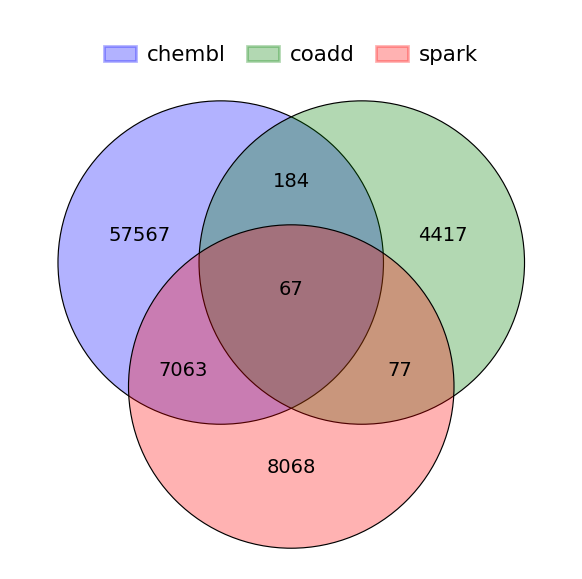

In [7]:
draw_venn(sets={"chembl": chembl_cmpds, "coadd": coadd_cmpds, "spark": spark_cmpds})

# Merging compound activities from different data resource

In [8]:
data = []

for inchikey in tqdm(combined_df["compound_inchikey"].unique()):
    if pd.isna(inchikey):
        continue

    tmp = combined_df[combined_df["compound_inchikey"] == inchikey]

    if len(tmp) == 1:
        data.append(tmp.to_dict(orient="records")[0])
    else:
        activity_data = tmp[["gram-positive", "gram-negative", "fungi", "acid-fast"]]

        # get median value column wise and if entry is NaN, then get the median of the non-NaN value
        activity_data = activity_data.fillna(activity_data.median()).median()
        data.append(
            {
                "compound_inchikey": inchikey,
                "compound_smiles": tmp["compound_smiles"].values[0],
                "compound_source": ", ".join(tmp["compound_source"].unique()),
                "gram-positive": activity_data["gram-positive"],
                "gram-negative": activity_data["gram-negative"],
                "fungi": activity_data["fungi"],
                "acid-fast": activity_data["acid-fast"],
            }
        )

  0%|          | 0/77443 [00:00<?, ?it/s]

100%|██████████| 77443/77443 [03:14<00:00, 397.24it/s]


In [9]:
final_df = pd.DataFrame(data)
final_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_33,5.0,5.0,NaN,6.0
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_33,NaN,NaN,6.0,NaN
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_33,6.0,6.5,NaN,NaN
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_33,6.0,6.0,NaN,NaN
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_33,7.5,7.0,NaN,NaN


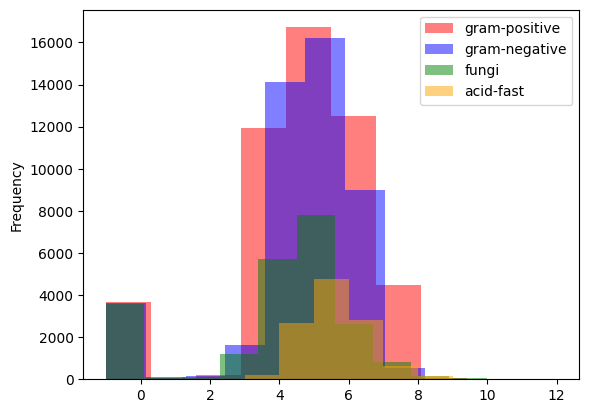

In [10]:
fig, ax = plt.subplots(1, 1)
final_df["gram-positive"].plot(kind="hist", ax=ax, alpha=0.5, color="red")
final_df["gram-negative"].plot(kind="hist", ax=ax, alpha=0.5, color="blue")
final_df["fungi"].plot(kind="hist", ax=ax, alpha=0.5, color="green")
final_df["acid-fast"].plot(kind="hist", ax=ax, alpha=0.5, color="orange")
plt.legend()
plt.show()

In [13]:
final_df["compound_inchikey"].nunique(), final_df["compound_smiles"].nunique()

(77442, 77442)

# Find chemical classes

In [21]:
CLASSIFIER_URL = "https://npclassifier.ucsd.edu/classify?smiles="

In [29]:
def get_chemical_class(smiles_string):
    structure_class = requests.get(CLASSIFIER_URL + smiles_string)
    if structure_class.status_code == 200:
        data_dict = structure_class.json()
        return {
            i: j
            for i, j in data_dict.items()
            if i in ["class_results", "superclass_results", "pathway_results"]
        }
    else:
        return None

In [30]:
if os.path.exists(f"{DATA_DIR}/mapping/structure2class.json"):
    with open(f"{DATA_DIR}/mapping/structure2class.json", "r") as f:
        structure_classes = json.load(f)
else:
    structure_classes = {}

In [34]:
skipped = set()

for smiles in tqdm(final_df["compound_smiles"].unique()):
    if smiles in structure_classes or smiles in skipped:
        continue

    structure_classes[smiles] = get_chemical_class(smiles)

 18%|█▊        | 13824/77442 [06:10<28:25, 37.31it/s]   


KeyboardInterrupt: 

In [35]:
len(skipped), len(structure_classes)

(0, 13824)

In [36]:
# caching the results
with open(f"{DATA_DIR}/mapping/structure2class.json", "w") as f:
    json.dump(structure_classes, f, ensure_ascii=False, indent=4)